In [102]:
import pandas as pd
import tensorflow as tf
import wave
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import python_speech_features as psf

from sklearn.model_selection import train_test_split
from scipy.signal import spectrogram
from tqdm import tqdm

%matplotlib inline

In [100]:
DATA_PATH = '/home/yvolkov/IFMO/pcmi/speech_ds'
UNKNOWN_WORD = 'UNKNOWN'

# Data uploading

# Data preview

In [57]:
#random wav

w_read = wave.open( os.path.join(DATA_PATH, 'yes', 
                                 'c25a032b_nohash_1.wav'))

print(w_read.getnchannels())
print(w_read.getnframes())
print(w_read.getparams())
w_bytes = w_read.readframes(-1)
frames = np.array(list(map(lambda i: int(w_bytes[i]+w_bytes[i+1]), 
                  range(0, 32000, 2))))

1
16000
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=16000, comptype='NONE', compname='not compressed')


/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


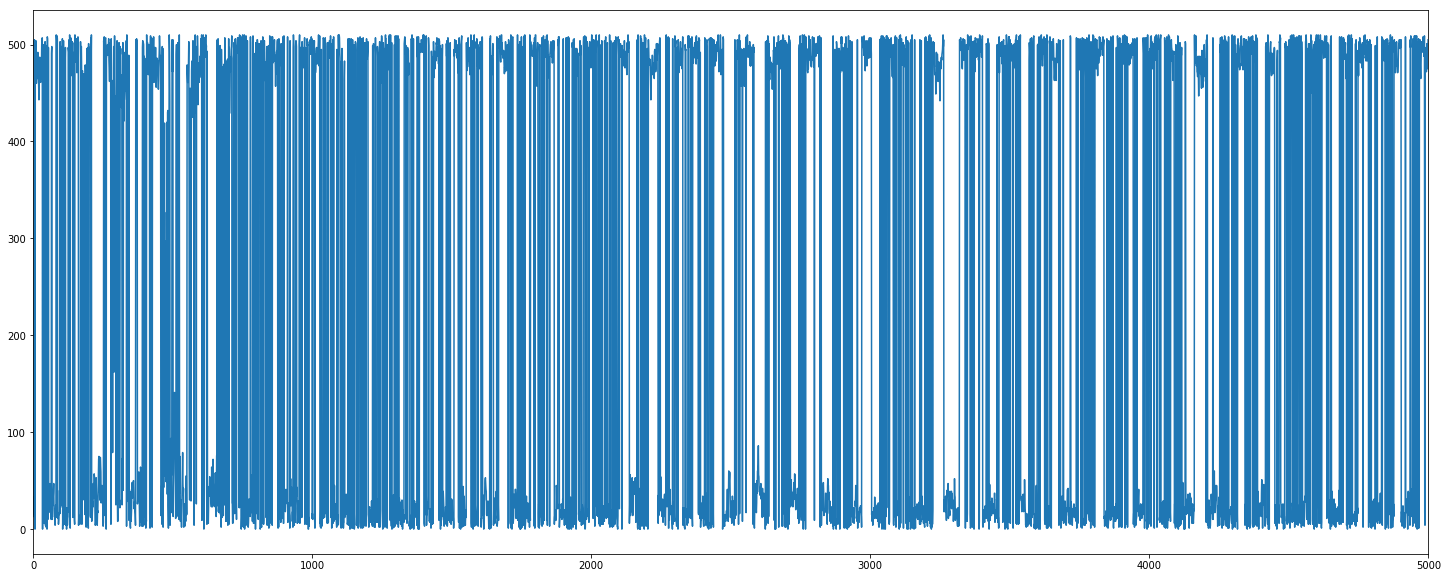

In [66]:
#Usual amplitude plot

plt.figure(figsize=(25, 10))
sns.tsplot(frames[:5000])

(129,) (71,) (129, 71)


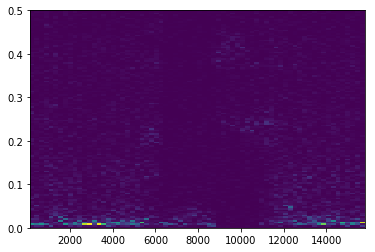

In [65]:
#Build spectrogram of signal

f, t, Sxx = spectrogram(frames)
print(f.shape, t.shape, Sxx.shape)
plt.pcolormesh(t, f, Sxx)

(99, 13)


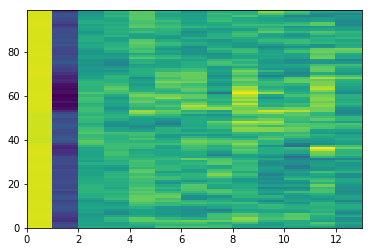

In [72]:
#Applying mfcc transform to initial recors
mfcc_frame = psf.mfcc(frames)
print(mfcc_frame.shape)
plt.pcolormesh(mfcc_frame)

# Data preparation

## Functions

In [116]:
def wav2mfcc(path):
    """
        Compute MFCC features for WAV file 
        uploaded from `path`.
        
        :param path: str
        
        :return: numpy array
            Array with shape (None, None)
    """
    
    wav_read = wave.open(path)
    params = wav_read.getparams()

    if (params.nchannels != 1) or (params.sampwidth != 2):
        raise ValueError('Incorrect input audio.')
    
    wav_bytes = wav_read.readframes(params.nframes)
    wav_amplitudes = map(lambda i: int(wav_bytes[i] + wav_bytes[i+1]),
                         range(0, params.nframes, 2))
    
    wav_mfcc = psf.mfcc(np.array(list(wav_amplitudes)))
    
    return wav_mfcc

class AudioPreprocessor:
    
    def __init__(self, data_path, target_words, 
                 noise_words, test_size, batch_size=64):
        self.data_path = data_path
        self.target_words = target_words
        self.noise_words = noise_words
        self.test_size = test_size
        self.batch_size = batch_size
        
        self.word2label = {i: self.target_words.index(i)
                           for i in self.target_words}
        self.word2label[UNKNOWN_WORD] = len(self.target_words)
        
        self._split_data_()
        
    def get_train_batch():
        for i in range(0, 
                       len(self.X_train) - self.batch_size,
                       self.batch_size):
            yield {'X': self.X_train,
                   'y': self.y_train}
        
    def _split_data_(self):
        X, y = [], []
        
        for word in tqdm(self.target_words):
            word_data_path = os.path.join(self.data_path, word)
            wav_names = os.listdir(word_data_path)
            
            X += wav_names
            y += [self.word2label[word]] * len(wav_names)
        
        for word in tqdm(self.noise_words):
            word_data_path = os.path.join(self.data_path, word)
            wav_names = os.listdir(word_data_path)
            
            X += wav_names
            y += [self.word2label[UNKNOWN_WORD]] * len(wav_names)
        
        (X_train, X_test, 
         y_train, y_test) = train_test_split(X, y,
                                             test_size=self.test_size,
                                             shuffle=True)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        

## Demonstration

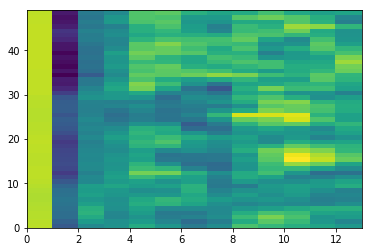

In [112]:
plt.pcolormesh(wav2mfcc(os.path.join(DATA_PATH, 'yes', 
                                 'c1d39ce8_nohash_3.wav')))

In [114]:
audio_p = AudioPreprocessor(DATA_PATH, 
                            target_words=['yes', 'no'], 
                            noise_words=['cat', 'dog'],
                            test_size=0.1)

100%|██████████| 2/2 [00:00<00:00, 428.84it/s]


# Building models